<div id="image">
<img src="https://www.imt-atlantique.fr/sites/default/files/logo_mt_0_0.png" WIDTH=280 HEIGHT=280>
</div>
<div id="subject">
<CENTER>
</br>
    
</CENTER>
<font size="5"></br> Copernicus Master on Digital Earth</font></br></div>
</CENTER>
<CENTER>
<font size="3"></br>December 25th 2023</font></br></div>
</CENTER>
<CENTER>
<span style="color:blue">Lecturer: lucas.drumetz@imt-atlantique.fr</span>

<span style="color:blue">Student: Maritim Leila</span>
</CENTER>

</div>

# Lab Session: Dimension reduction

The goal of this lab is to get familiar with the concept of dimension reduction and visualization for high-dimensional data, using Principal Component Analysis (PCA)

In [71]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, exposure
from sklearn.decomposition import PCA
import os

In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
os.chdir('/content/drive/MyDrive/DIMENSIONALITY REDUCTION/lab_session_pca_2023')

# Principal Component Analysis

The goal of this section is to perform PCA on a real hyperspectral dataset to see how it can help visualize, compress and interpret high dimensional remote sensing data. We will make use of the functions implemented in sci-kit learn, the standard Machine Learning Package for Python.

The data is provided courtesy of Naoto Yokoya and Japan Space Systems (only for this lab, please do not distribute). See

Matsuki, T., Yokoya, N., & Iwasaki, A. (2015). Hyperspectral tree species classification of Japanese complex mixed forest with the aid of LiDAR data. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 8(5), 2177-2187.

for more details.

First we load and visualize the data:

(207, 268)


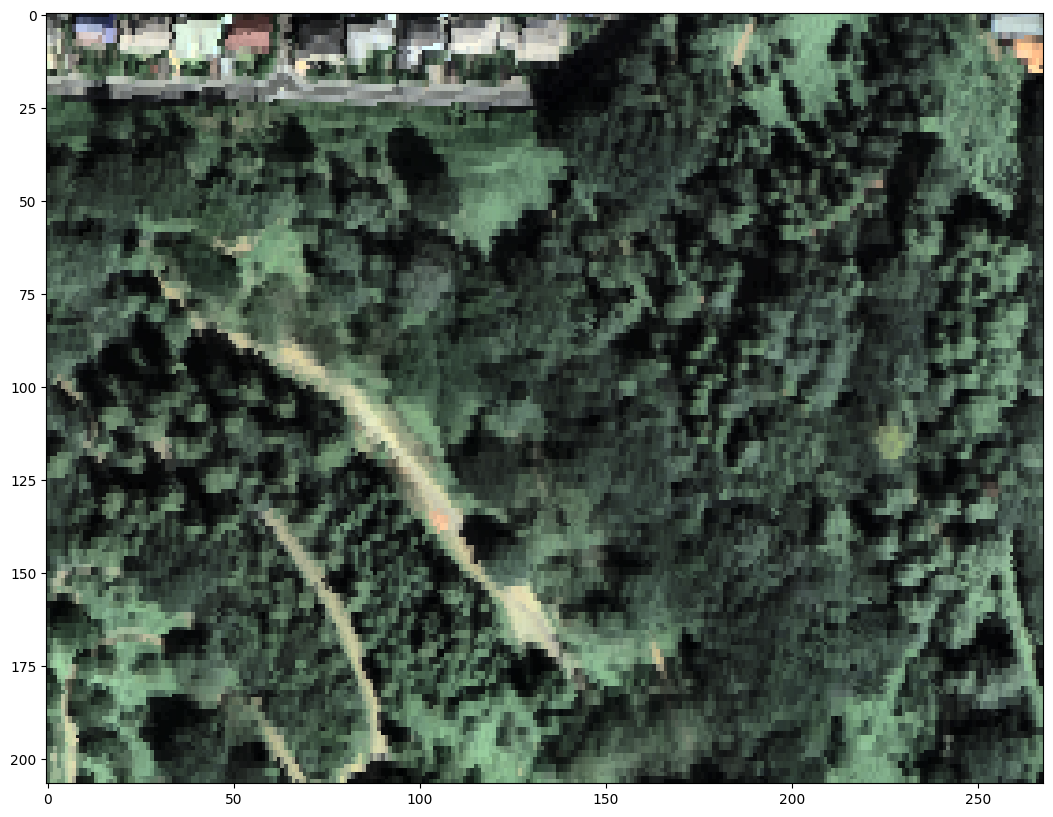

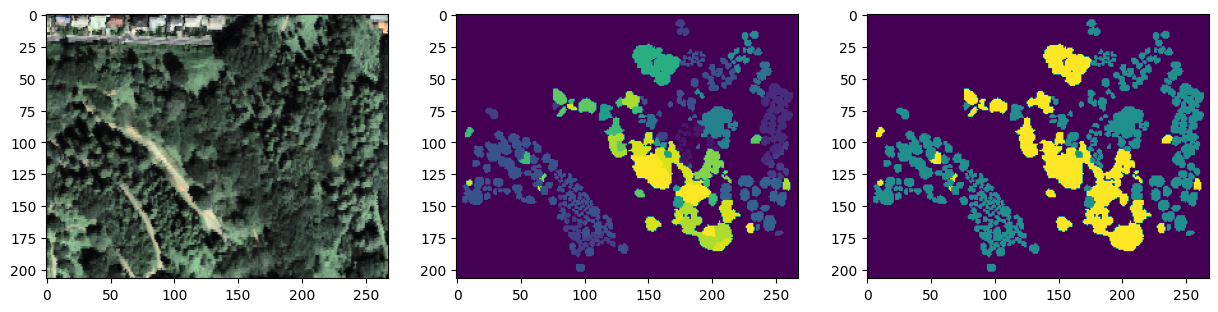

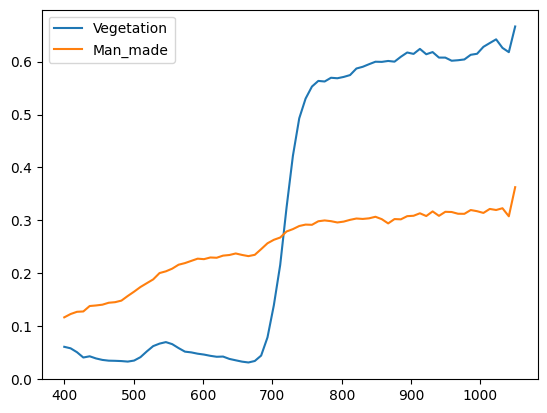

In [74]:
data = sio.loadmat("./CASI3_North.mat")
rgb_data = sio.loadmat("rgb.mat")
classinfo = sio.loadmat("./GT_North.mat")

wavelengths = np.linspace(400,1050,72) # 72 wavelenghts in the visible and near IR

im = data['hyper'].astype("double")


im = (im - np.amin(im))/(np.amax(im) - np.amin(im)) # rescale data between 0 and 1

imrgb = rgb_data['rgb_adjust']

class_img = classinfo['class']

# get labels for both classes: conifer trees and broadleaf trees

binary_class_img = np.zeros(np.shape(class_img))

print(binary_class_img.shape)

binary_class_img[class_img <=9] = 1 # conifer
binary_class_img[class_img >9] = 2 # broadleaf
binary_class_img[class_img == 0] = 0 # unclassified


# display

plt.figure(figsize=(15,10))
plt.imshow(imrgb)

plt.figure(figsize=(15,10))
plt.subplot(131)
plt.imshow(imrgb)
plt.subplot(132)
plt.imshow(class_img)
plt.subplot(133)
plt.imshow(binary_class_img)

plt.figure()
plt.plot(wavelengths, im[50,50,:],label='Vegetation') # one vegetation pixel
plt.plot(wavelengths, im[112,90,:],label='Man_made') # one man made pixel
plt.legend()




**Q: What are the main broad classes of materials that are present in the image?**

*The most prevalent classes are vegetation(broadleaf and conifer)*

(72, 55476)
(72, 7726)
(72, 4895)


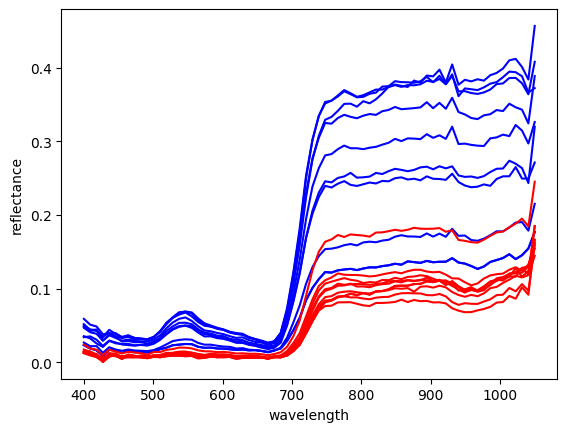

555.6338028169014
702.1126760563379


In [75]:
# %matplotlib qt
%matplotlib inline

[m,n,L] = np.shape(im)
im_r = np.reshape(im,(m*n,L)).T #  Reshapes the 3D data cube into a 2D matrix of size L×(m×n), where each column corresponds to a pixel in the original image.
print(im_r.shape)

conifer_pixels = im[binary_class_img == 1,:].T
print(conifer_pixels.shape)  #matrix has dimensions[L,number of conifer pixels].

broadleaf_pixels = im[binary_class_img == 2,:].T
print(broadleaf_pixels.shape)


plt.figure()
plt.plot(wavelengths,conifer_pixels[:,0:10], 'b')
plt.plot(wavelengths,broadleaf_pixels[:,0:10],'r')
plt.xlabel('wavelength')
plt.ylabel('reflectance')
plt.show()

print(wavelengths[17]) #wavelength at index 17
print(wavelengths[33]) #wavelength at index 33

**Q: What are the main differences between spectra of conifer and broadleaf trees?**

*Generally, in the visible spectrum, we note an absorption of light then at 700nm, there is a sharp rise beyond which is characterized by high reflection of incident light. This sharp rise is known as the red edge. However, these two vegetation types have distinct reflectance signatures*
*conifer(blue) has higher spectral  values as compared to broadleaf and between wavelength 500 and 600, there is a rising trajectory noted which is not present for broadleaf. Conifer also has a sharper rise in the red edge i.e increase in refelctance and this characteristic can be used to distinguish these vegetation types.*

*An exceptional behaviour is observed for two broadleaf pixels and one conifer pixel where the conifer pixel beyond the red edge has higher reflectance than that of the two conifer pixels.*

**Q: First plot the mean value of the data (the mean spectrum over all pixels). Does it look more like a vegetation spectrum or the spectrum of some artificial material? Why?**

*It still has the distinct reflectance curve for vegetation because all the pixels at various wavelengths behave similarly for the different vegetation types(conifer and broadleaf)*

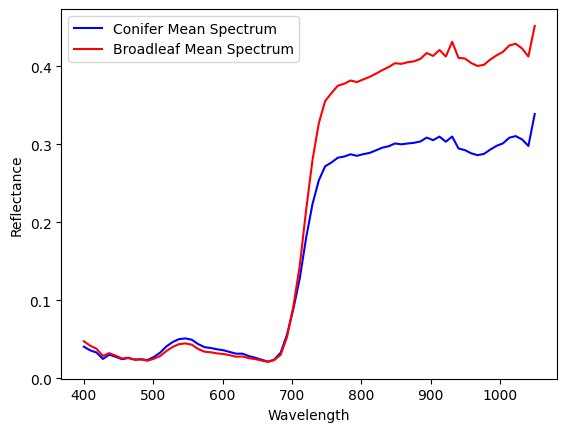

In [76]:
## TO DO ##
#What dimension to compute the mean? Each column represents a pixel and we want to find the mean reflectance over the entire spectrum hence we compute the mean along axis =1
# Calculate mean spectra
mean_conifer_spectrum = np.mean(conifer_pixels, axis=1)
mean_broadleaf_spectrum = np.mean(broadleaf_pixels, axis=1)

# Plot the mean spectra
plt.figure()
plt.plot(wavelengths, mean_conifer_spectrum, 'b', label='Conifer Mean Spectrum')
plt.plot(wavelengths, mean_broadleaf_spectrum, 'r', label='Broadleaf Mean Spectrum')
plt.xlabel('Wavelength')
plt.ylabel('Reflectance')
plt.legend()
plt.show()


We will use the built-in scikit learn functions to represent the principal components and the coefficients.

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

**Q: Use the PCA class to compute the decomposition, using pca.fit, with 72 components (all of them).\
Plot the eigenvalues, together with the explained variance as functions of the component number, you can recover them with pca.singular_values_ and pca.explained_variance_ratio_.**

**Similarly, use pca.components to recover the components, and plot them. What do they look like and what are their dimensions?**

*(72, 55476) *

**Finally, compute the coefficients of the decomposition using pca.transform. What are their dimensions?**

*Dimensions of Coefficients: (55476, 72)*

**You can represent them as images, if you reshape them (use the function numpy.reshape for that).**

**Can you interpret some of the components using the coefficients as well as the components themselves (what do they represent)?**



Explained variance: the fraction of total variance explained by the components M<D


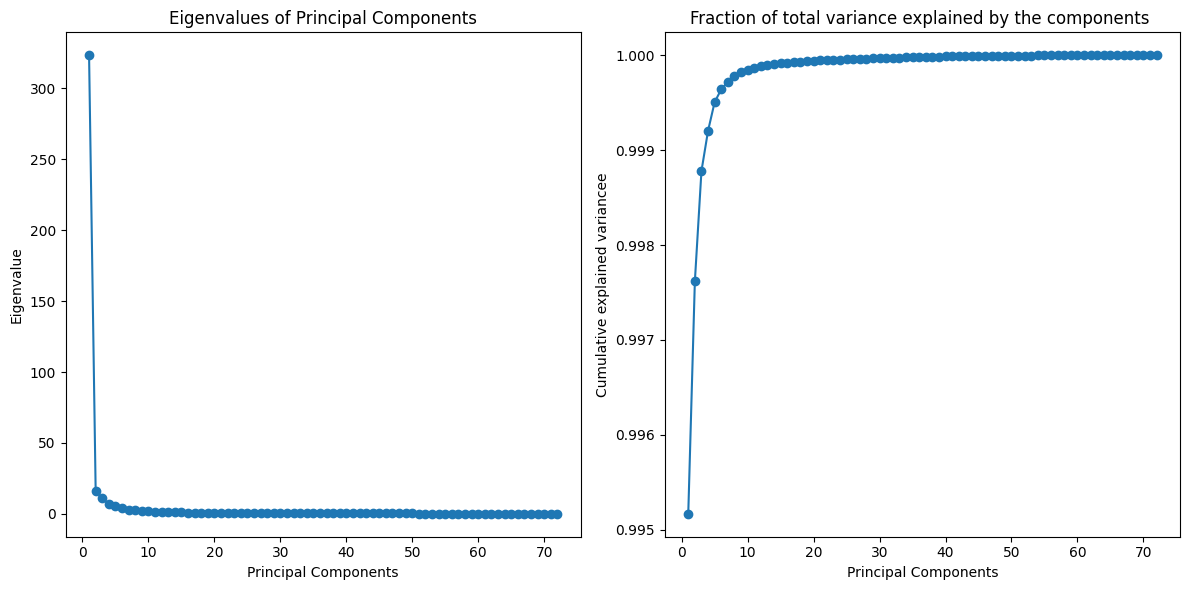

In [77]:
# PCA components

# Compute the PCA

n_components = 72
pca = PCA(n_components=n_components)

# Fit PCA
pca.fit(im_r)
## TO DO ##

# Get eigenvalues
eigenvalues=pca.singular_values_
## TO DO ##
explained_var_ratio=pca.explained_variance_ratio_
# display

## TO DO ##
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(range(1, n_components + 1), eigenvalues, marker='o')
plt.title('Eigenvalues of Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Eigenvalue')

plt.subplot(1,2,2)
plt.plot(range(1, n_components + 1), np.cumsum(explained_var_ratio), marker='o')
plt.title('Fraction of total variance explained by the components ')
plt.xlabel('Principal Components')
plt.ylabel('Cumulative explained variancee')

plt.tight_layout()
plt.show()


The top eigenvalue contains the most information.

Dimensions of Components: (72, 72)


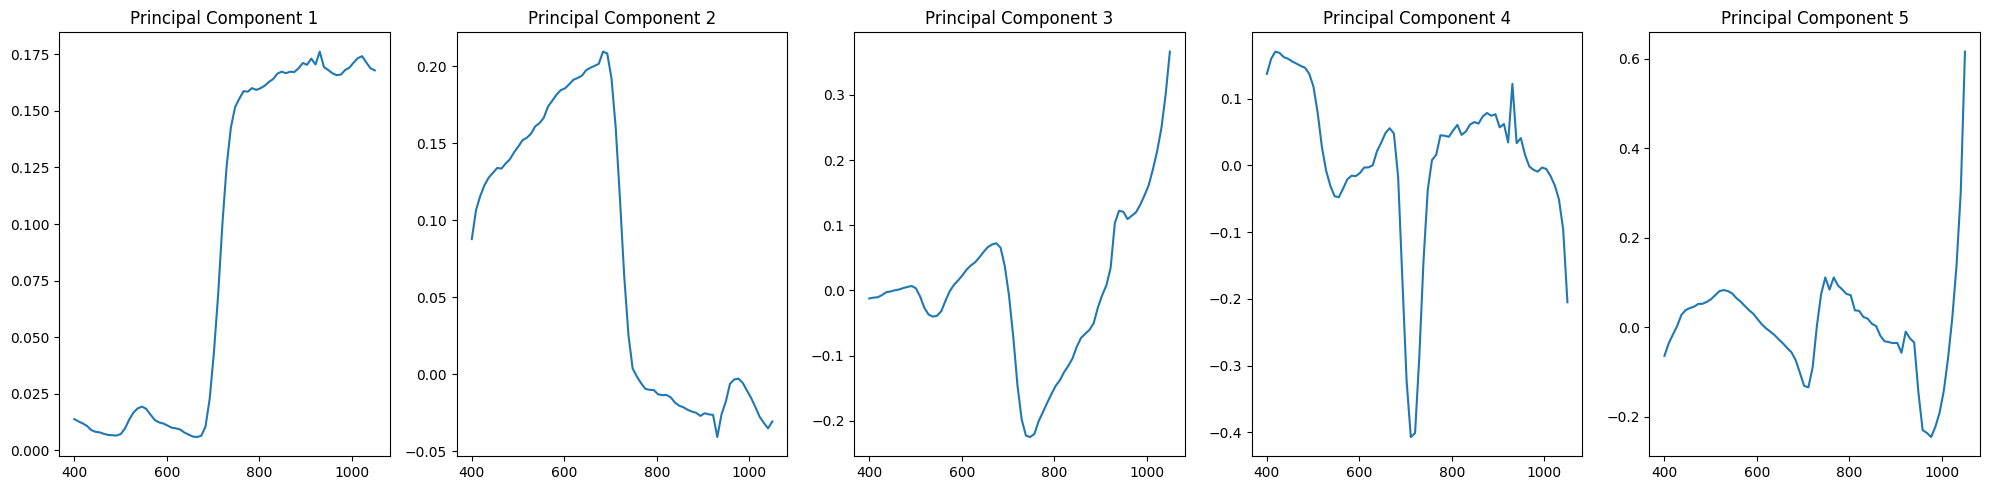

In [88]:
# display principal components and coefficients


n_components_displayed = 5

# get components and plot the first few of them
comp=pca.components_
# Dimensions of the components
print("Dimensions of Components:", comp.shape)

## TO DO ##
plt.figure(figsize=(20, 5))
for i in range(n_components_displayed):
    plt.subplot(1, n_components_displayed, i + 1)
    plt.plot(wavelengths,comp[i, :],label=f'Component {i + 1}')
    plt.title(f'Principal Component {i + 1}')
    #plt.colorbar()


plt.tight_layout()
plt.show()


In [ ]:

n_components =   # Number of components to display

# Fit PCA model
pca = PCA(n_components=n_components)
pca.fit(data)

# Get components
components = pca.components_

# Dimensions of the components
print("Dimensions of Components:", components.shape)

# Wavelengths (adjust based on your data)
wavelengths = np.linspace(400, 1050, L)

# Display the first few components as spectral signatures
plt.figure(figsize=(20, 5))
for i in range(n_components):
    plt.subplot(1, n_components, i + 1)
    plt.plot(wavelengths, components[i, :], label=f'Component {i + 1}')
    plt.title(f'Principal Component {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Amplitude')
    plt.legend()

plt.tight_layout()
plt.show()


The brighter regions in the images have higher values

Dimensions of Coefficients: (55476, 72)


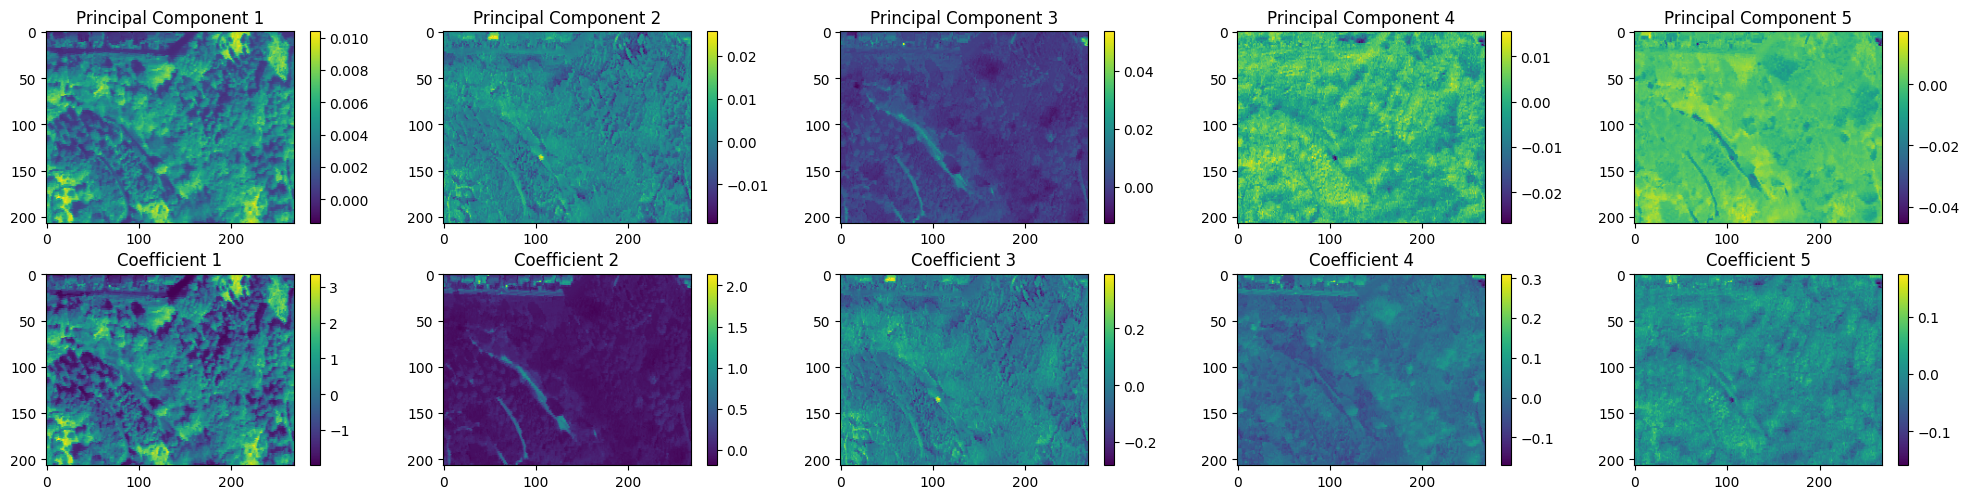

In [86]:
# get scores (coefficients of decomposition) i.e the projections of the original data on to the principal components
im_r1 = np.reshape(im,(m*n,L))

pca.fit(im_r1)
## TO DO ##
coefficients = pca.transform(im_r1)
# Dimensions of the coefficients
print("Dimensions of Coefficients:", coefficients.shape)

# display both components and scores together
plt.figure(figsize=(20, 5))
for i in range(n_components_displayed):
    plt.subplot(2, n_components_displayed, i + 1)
    plt.imshow(np.reshape(comp[i, :], (m, n)), cmap='viridis')
    plt.title(f'Principal Component {i + 1}')
    plt.colorbar()

    plt.subplot(2, n_components_displayed, n_components_displayed+i+1)
    coefficient_image = np.reshape(coefficients,(m,n,L))
    plt.imshow(coefficient_image[:,:,i], cmap='viridis')
    plt.title(f'Coefficient {i + 1}')
    plt.colorbar()

    plt.subplot

plt.tight_layout()
plt.show()




**Q: Almost all the variance in the data is explained by only a few components: are they interpretable? What parts of the image do they explain, respectively?**

*The bright and dark regions represent areas in the original data where variance is maximal. The first component represents the vegetation spectral signature. It is also noted that the coefficient values are higher in the first componet(decreases going on to PC5) *

We define a function to enhance the brigthness of an RGB image:

In [ ]:
# from skimage import color, exposure

def enhance_brightness_rgb(rgb_original):
    yuv= color.rgb2yuv(rgb_original) # change color space to radiance, chrominance
    p_low, p_high = np.percentile(yuv[:,:,0], (0.1,99.9)) # saturate outlier values in radiance (0.1,99.9)
    yuv[:,:,0] = exposure.rescale_intensity(yuv[:,:,0], in_range=(p_low, p_high)) # rescale radiance
    mod_rgb =  color.yuv2rgb(yuv) # transform back to rgb space
    return mod_rgb


**Q: The dataset can be projected in the 2D latent space given by the first 2 principal components (each pixel is represented only by the first two coefficients of the PCA decomposition). Make a scatterplot of the data points in the space spanned by the first 2 eigenvectors. Can you locate vegetation pixels, and others?**

You can use as colors the binary image with the class labels to spot conifer and broadleaf pixels.

*The yellow points are  broadleaf and the green ones are conifer*

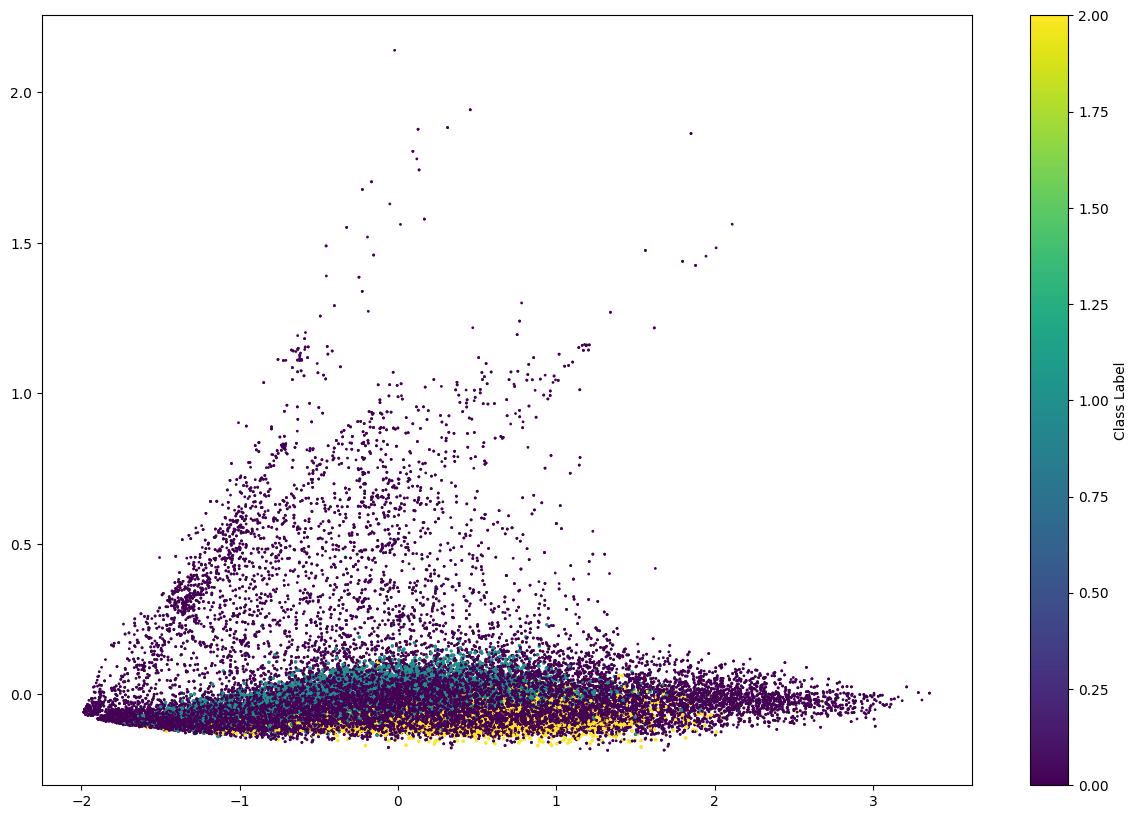

In [ ]:
plt.figure(figsize = (15,10))
plt.scatter(coefficients[:,0],coefficients[:,1] , c = binary_class_img.ravel(),s=(1+(binary_class_img.ravel()!= 0)))
plt.colorbar(label='Class Label')

**Q: Reconstruct the image using 1,2,5,10 and 72 components. Visually assess and describe in each case how well the data is reconstructed (e.g. by comparing the reconstructed rgb image with the true one, or plotting reconstructed spectra). Compute the mean absolute error in each pixel in each case**

The reconstruction for all data points using K components can be obtained by computing:
\begin{equation*}
\hat{\mathbf{X}} = \bar{\mathbf{X}} + \mathbf{U}_{K}\mathbf{A}_{K}
\end{equation*}
where $\hat{\mathbf{X}}\in\mathbb{R}^{D\times N}$, and  $\mathbf{U}\in \mathbb{R}^{D\times K}$, and $\mathbf{A}^{K\times N}$. $\bar{\mathbf{X}}\in\mathbb{R}^{D\times N}$ is  a matrix containing the mean of the data in each column.

In [94]:
# reconstruct image from only a few components

# rgb image

k_values = [1,2,5,10,50]


mean=pca.mean_
print(comp.shape)
print(coefficients.shape)
print(mean.shape)##

mae=[]
plt.figure(figsize=(30, 15))
for i, k in enumerate(k_values, 1):
    # Reconstruct image using the specified number of PCs
    reconstructed_image = mean + np.dot(coefficients[:, :k], components[:k, :])
    rec_im = np.reshape(reconstructed_image, (m, n, L))

    # Compute mean absolute error
    mean_absolute_error = np.abs(rec_im - im)
    mae_value = np.mean(mean_absolute_error)

    # Plot reconstructed image
    plt.subplot(3, len(k_values), i)
    plt.imshow(enhance_brightness_rgb(rec_im[:, :, [29, 18, 6]]))  # Adjust bands as needed
    plt.title(f'Reconstructed Image ({k} PCs)\nMAE: {mae_value:.4f}')

    # Plot original RGB image
    plt.subplot(3, len(k_values), len(k_values) + i)
    plt.imshow(enhance_brightness_rgb(imrgb))
    plt.title('Original Image')

    # Plot mean absolute error
    plt.subplot(3, len(k_values), 2 * len(k_values) + i)
    plt.imshow(mean_absolute_error[:, :, 0], cmap='viridis')  # Display a specific wavelength, adjust as needed
    plt.colorbar()
    plt.title(f'Mean Absolute Error ({k} PCs)')

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In terms of texture, using 1 PC, the reconstructed and original images are almost similar. As the number of PCs increases, we note a smoothing of the vegetation. The man-made features, on the other hand, are defined better as the number of PCs increases.

The earlier components capture the most dominant and global features, while the later components capture more local and subtle variations.The smoothing effect observed with increasing PCs is a result of combining multiple modes of variation. This tends to average out noise and capture the more stable and general patterns present in the data.

()
Mean absolute error for final reconstruction:  0.14


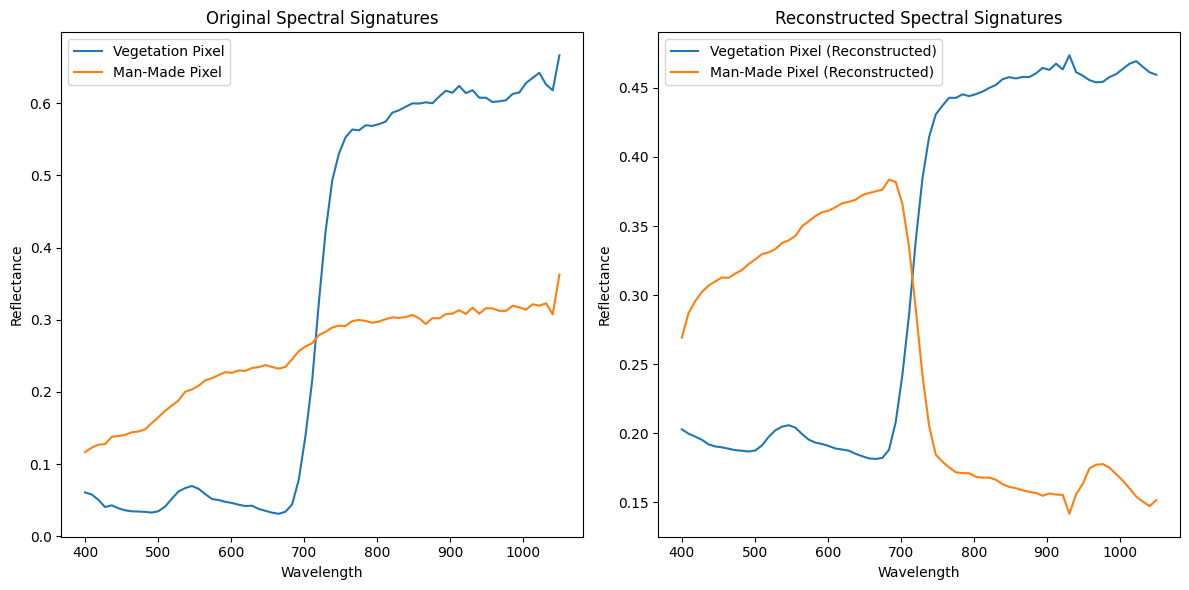

In [96]:
# keep 2 components

final_nbr = 2

# print( np.dot(comp[:final_nbr,:].T,coefficients[:,:final_nbr].T).T.shape)
# print(comp[:final_nbr,:].shape)

mean =  np.mean(im_r)
print(mean.shape)

reconstructed_image_final = mean + np.dot(coefficients[:, :final_nbr], components[:final_nbr, :])
rec_im_final = np.reshape(reconstructed_image_final,(m,n,L))

# absolute difference
mean_absoulte_error = np.abs(rec_im_final - im)
print('Mean absolute error for final reconstruction: ', np.round(np.mean(mean_absoulte_error), 3))

# Plot spectral signature of specific pixels before and after the reconstruction
plt.figure(figsize=(12, 6))

# Plot original spectral signatures
plt.subplot(1, 2, 1)
plt.plot(wavelengths, im[50, 50, :], label='Vegetation Pixel')
plt.plot(wavelengths, im[112, 90, :], label='Man-Made Pixel')
plt.title('Original Spectral Signatures')
plt.xlabel('Wavelength')
plt.ylabel('Reflectance')
plt.legend()

# Plot reconstructed spectral signatures
plt.subplot(1, 2, 2)
plt.plot(wavelengths, rec_im_final[50, 50, :], label='Vegetation Pixel (Reconstructed)')
plt.plot(wavelengths, rec_im_final[112, 90, :], label='Man-Made Pixel (Reconstructed)')
plt.title('Reconstructed Spectral Signatures')
plt.xlabel('Wavelength')
plt.ylabel('Reflectance')
plt.legend()

plt.tight_layout()
plt.show()



**Q: Finally, take a look at the last components and the associated coefficients. Are the components easy to interpret? How about the coefficients: what do they look like? Is it worth it to keep all the components (give 2 reasons why or why not)**

*The spectral signature reprsented by the last component is not interpretable. We would not be able to tell what feature it represents. The image(coefficient image) is also characterized by lots of noise. This serves to show that keeping the last component would mean we are adding noise to our data. No meaningful information is added.

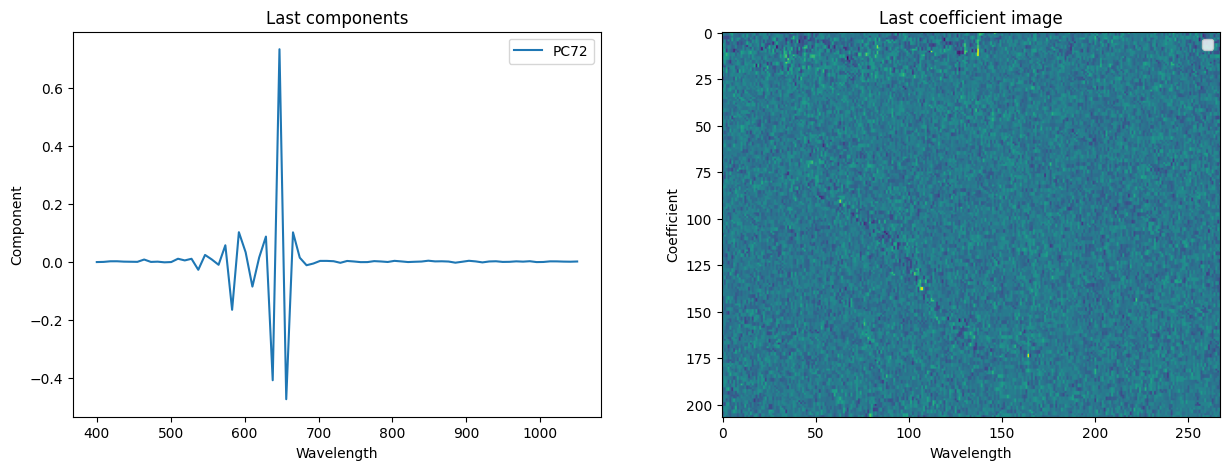

In [100]:
# last components
last_comp=comp[-1,:]
last_coeff=coefficients[:,-1]

coefficient_image = np.reshape(coefficients,(m,n,L))
#plt.imshow(coefficient_image[:,:,-1], cmap='viridis')


## TO DO ##
plt.figure(figsize = (15,5))
plt.subplot(121)
plt.plot(wavelengths, last_comp, label = 'PC72')
plt.xlabel('Wavelength')
plt.ylabel('Component')
plt.legend()
plt.title('Last components')

plt.subplot(122)
plt.imshow(coefficient_image[:,:,-1], cmap='viridis')
plt.xlabel('Wavelength')
plt.ylabel('Coefficient')
plt.legend()
plt.title('Last coefficient image')
plt.show()

**Q: Bonus: Now perform a new PCA decomposition using only as a dataset the set of labeled pixels. Plot the dataset in the 2D space spanned by the first two components. What can you say about the new components and the separability of both classes rather than in the PCA space of the whole dataset?**

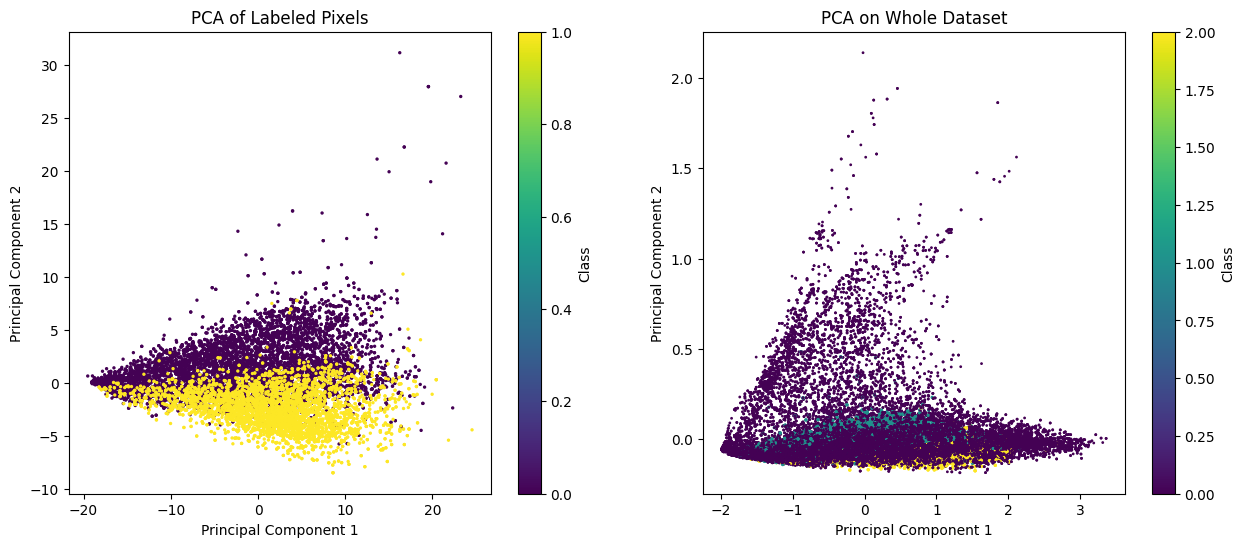

In [121]:
#%matplotlib qt
%matplotlib inline

nb_conifer_pixels = np.shape(conifer_pixels[1])
nb_broadleaf_pixels = np.shape(broadleaf_pixels[1])

new_data = np.concatenate((conifer_pixels,broadleaf_pixels),axis = 1)
# Normalize the data
new_data_normalized = (new_data - np.mean(new_data, axis=1, keepdims=True)) / np.std(new_data, axis=1, keepdims=True)
# Compute the PCA

pca2 = PCA(n_components=72)
# Fit PCA on the data
pca2.fit(new_data_normalized.T)
# transform data
coefficients2 = pca2.transform(new_data_normalized.T)

binary_class_img_ = np.concatenate((np.zeros(nb_conifer_pixels), np.ones(nb_broadleaf_pixels)))

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

scatter1=axes[0].scatter(coefficients2[:, 0], coefficients2[:, 1], c=binary_class_img_, s=2, cmap='viridis')
axes[0].set_title('PCA of Labeled Pixels')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')
fig.colorbar(scatter1, ax=axes[0], label='Class')


scatter2=axes[1].scatter(coefficients[:,0],coefficients[:,1] , c = binary_class_img.ravel(),s=(1+(binary_class_img.ravel()!= 0)))
axes[1].set_title('PCA on Whole Dataset')
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')
fig.colorbar(scatter2, ax=axes[1], label='Class')
plt.show()

*If we use the whole dataset and two components, we cannot separate between the conifer and broadleaf. Separability improves when we use the labelled dataset only. However, we still have some overlap between the two classes.The two components therefore are not sufficient in accurately separating the two classes. More components would have to be considered. It is important to also note as observed before that the decision on the number of componets to use is a tradeoff because the more components are used, the more noise is introduced. Based on the cumulative explained variance ratio, approximately 5 components would ensure that a significant portion of informaton is retained*